In [1]:
import sys

#sys.path.append('/root/lib/')

import ROOT as r
import os
import json
import pandas as pd
import uproot 
import awkward as ak
import array as arr
import numpy as np
import shutil

sys.path.append(os.getcwd()+ '/../utilities/')
from milliqanProcessor import *
from milliqanScheduler import *
from milliqanCuts import *
from milliqanPlotter import *

In [2]:
@mqCut
def panelTimeDiff(self):

    for i in range(16):
        layer = i//4
        column = i%4

        if i < 8:
            panelLayer = 0
        else:
            panelLayer = 2

        #require bar hits in specific path
        pathMask = (self.events['layer'] == layer) & (self.events['column'] == column) & (self.events['type'] == 0)

        panelInfoMask = (self.events['type']==2) & (self.events['layer']==panelLayer)

        panelInfo = ak.zip({
            "panelTimes": self.events['timeFit'],
            "chan": self.events['chan'],
        })

        panelInfo = panelInfo[panelInfoMask]
        
        info = ak.zip({
            "rows":self.events['row'],
            "times":self.events['timeFit'], 
            "chan": self.events['chan'],
        })
        

        #rows = self.events['row'][pathMask]
        info = info[pathMask]
        
        #require panel hit in event
        panelMask = ak.any(self.events['type'] == 2, axis=1)
        _, panelMaskMod = ak.broadcast_arrays(panelInfo['panelTimes'], panelMask)
        _, panelMask = ak.broadcast_arrays(info['times'], panelMask)
        info = ak.mask(info, panelMask)
        panelInfo = ak.mask(panelInfo, panelMaskMod)
        
        #require there are at least 3 in a line
        lineCut = ak.count(info['rows'], axis=1) >= 3
        _, lineCutMod = ak.broadcast_arrays(panelInfo['panelTimes'], lineCut)
        _, lineCut = ak.broadcast_arrays(info['rows'], lineCut)

        info = info[lineCut]
        panelInfo = panelInfo[lineCutMod]
        
        #find time differences
        combos = ak.combinations(info, 2, axis=1)
        time_diffs = abs(combos['0']['times'] - combos['1']['times'])
        max_vals = ak.max(time_diffs, axis=1)
        max_cut = max_vals < 100
        _, max_cutMod = ak.broadcast_arrays(panelInfo['panelTimes'], max_cut)
        _, max_cut = ak.broadcast_arrays(info['rows'], max_cut)
        info = info[max_cut]
        panelInfo = panelInfo[max_cutMod]


        panel_combos = ak.cartesian([panelInfo, info], axis=1)

        diffs = panel_combos['0']['panelTimes'] - panel_combos['1']['times']
        channels = panel_combos['0']['chan']

        self.events[f'panelTimeDiff_p{i}'] = diffs
        self.events[f'panelChannels_p{i}'] = channels
        
        num_hitsCheck = ak.count(info['rows'], axis=1)
        num_eventsCheck = ak.count(num_hitsCheck[num_hitsCheck >= 3], axis=-1)
        
        #print(ak.count(num_hitsCheck, axis=-1), "->", num_eventsCheck)

In [3]:
if __name__ == "__main__":

    filelist = [
        '/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1300_v35_cosmic_beamOff_tight.root',
        '/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1400_v35_cosmic_beamOff_tight.root',
        '/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1500_v35_cosmic_beamOff_tight.root',
        '/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1600_v35_cosmic_beamOff_tight.root',
        '/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1700_v35_cosmic_beamOff_tight.root',
        '/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1800_v35_cosmic_beamOff_tight.root',
        '/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1900_v35_cosmic_beamOff_tight.root',
    ]

    print("Running on files {}".format(filelist))

    #define the necessary branches to run over
    branches = ['event', 'tTrigger', 'boardsMatched', 'pickupFlag', 'pickupFlagTight', 'fileNumber', 'runNumber', 'type', 'ipulse', 'nPE', 'chan',
                'time_module_calibrated', 'timeFit_module_calibrated', 'row', 'column', 'layer', 'height', 'area', 'npulses', 'timeFit']


    #define the milliqan cuts object
    mycuts = milliqanCuts()

    setattr(milliqanCuts, "panelTimeDiff", panelTimeDiff)

    #require pulses are not pickup
    pickupCut = getCutMod(mycuts.pickupCut, mycuts, 'pickupCut', tight=True, cut=True, branches=branches)

    #require that all digitizer boards are matched
    boardMatchCut = getCutMod(mycuts.boardsMatched, mycuts, 'boardMatchCut', cut=True, branches=branches)

    #greater than or equal to one hit per layer
    hitInAllLayers = getCutMod(mycuts.oneHitPerLayerCut, mycuts, 'hitInAllLayers', cut=True, branches=branches, multipleHits=False)

    #exactly one hit per layer
    oneHitPerLayer = getCutMod(mycuts.oneHitPerLayerCut, mycuts, 'oneHitPerLayer', cut=True, branches=branches, multipleHits=False)

    #four layer cut
    fourLayerCut = getCutMod(mycuts.fourLayerCut, mycuts, 'fourLayerCut', cut=True, branches=branches)

    #panel veto
    panelVeto = getCutMod(mycuts.panelVeto, mycuts, 'panelVeto', nPECut=40e3, cut=True, branches=branches)

    #nPE Cut
    nPECut = getCutMod(mycuts.nPECut, mycuts, 'nPECut', nPECut=100, cut=True, branches=branches)

    #area cut
    areaCut = getCutMod(mycuts.areaCut, mycuts, 'areaCut', areaCut=300000, cut=True, branches=branches)

    #first pulse cut
    firstPulseCut = getCutMod(mycuts.firstPulseCut, mycuts, 'firstPulseCut', cut=True, branches=branches)

    #require front panel has hit
    #frontPanelHit = getCutMod(mycuts.frontPanelHit, mycuts, 'frontPanelHit', cut=True, branches=branches)

    #require hit time is in trigger window
    centralTime = getCutMod(mycuts.centralTime, mycuts, 'centralTime', cut=True, branches=branches)

    #create all plots for timing differences 64 paths, 3 timing differences each
    timingHistos = []
    cutNames = []
    nbins = 100
    minx = -50
    maxx = 50
    nbinsy = 10
    miny = 66
    maxy = 76
    for i in range(16):
        h_name1 = 'h_timeDiff_p{}'.format(i)
        h1 = r.TH2F(h_name1, 'Time Difference Path {}'.format(i), nbins, minx, maxx, nbinsy, miny, maxy)
        timingHistos.append(h1)

    cutflow = [mycuts.totalEventCounter, mycuts.fullEventCounter, 
                boardMatchCut, 
                pickupCut, 
                firstPulseCut,
                nPECut,
                centralTime,
                mycuts.panelTimeDiff,
                #fourLayerCut,
                #frontPanelHit,
                #mycuts.straightLineCut, 
                #mycuts.pulseTime,
                #mycuts.threeInLine,
                #mycuts.timeDiff,
                #mycuts.getTimeDiffs
            ]
    
    #define milliqan plotter
    myplotter = milliqanPlotter()
    myplotter.dict.clear()

    #myplotter.addHistograms(h_channels, 'chan')
    #myplotter.addHistograms(h_timeDiff, 'timeDiff')
    #myplotter.addHistograms(h_timeDiffNoCorr, 'timeDiffNoCorr')
    #myplotter.addHistograms(h_timeDiffOld, 'timeDiffOld')

    for i, h in enumerate(timingHistos):
        myplotter.addHistograms(h, [f'panelTimeDiff_p{i}', f'panelChannels_p{i}'])

    for key, value in myplotter.dict.items():
        if value not in cutflow:
            cutflow.append(value)

    #create a schedule of the cuts
    myschedule = milliQanScheduler(cutflow, mycuts, myplotter)

    #print out the schedule
    myschedule.printSchedule()

    #create the milliqan processor object
    myiterator = milliqanProcessor(filelist, branches, myschedule, step_size=10000, qualityLevel='override')

    #run the milliqan processor
    myiterator.run()

    myschedule.cutFlowPlots()

    #save plots
    myplotter.saveHistograms("panelTimingCorrection{}.root".format('_beamOff'))

    mycuts.getCutflowCounts()


Running on files ['/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1300_v35_cosmic_beamOff_tight.root', '/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1400_v35_cosmic_beamOff_tight.root', '/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1500_v35_cosmic_beamOff_tight.root', '/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1600_v35_cosmic_beamOff_tight.root', '/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1700_v35_cosmic_beamOff_tight.root', '/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1800_v35_cosmic_beamOff_tight.root', '/eos/experiment/milliqan/skims/cosmic/MilliQan_Run1900_v35_cosmic_beamOff_tight.root']
----------------------------
MilliQan Scheduler:
	0. totalEventCounter
	1. fullEventCounter
	2. boardMatchCut
	3. pickupCut
	4. firstPulseCut
	5. nPECut
	6. centralTime
	7. panelTimeDiff
	8. h_timeDiff_p0
	9. h_timeDiff_p1
	10. h_timeDiff_p2
	11. h_timeDiff_p3
	12. h_timeDiff_p4
	13. h_timeDiff_p5
	14. h_timeDiff_p6
	15. h_timeDiff_p7
	16. h_timeDiff_p8
	17. h_tim

In [ ]:
#now start to analyze the output files

In [4]:
fin = r.TFile.Open("panelTimingCorrection_beamOff.root")
c1 = r.TCanvas("c1", "c1", 800, 600)

In [5]:
h_timeDiffs = []
for i in range(16):
    h = fin.Get(f'h_timeDiff_p{i}')
    h_timeDiffs.append(h)

In [6]:
h_timeDiff_68 = r.TH1F("h_timeDiff_68", "Panel 68 Time Diff", 100, -50, 50)
h_timeDiff_70 = r.TH1F("h_timeDiff_70", "Panel 70 Time Diff", 100, -50, 50)
h_timeDiff_72 = r.TH1F("h_timeDiff_72", "Panel 72 Time Diff", 100, -50, 50)

h_timeDiff_69 = r.TH1F("h_timeDiff_69", "Panel 69 Time Diff", 100, -50, 50)
h_timeDiff_71 = r.TH1F("h_timeDiff_71", "Panel 71 Time Diff", 100, -50, 50)
h_timeDiff_73 = r.TH1F("h_timeDiff_73", "Panel 73 Time Diff", 100, -50, 50)

for i, h in enumerate(h_timeDiffs):
    
    for ibin in range(h.GetNbinsX()):

        if i < 8:
            bin68 = h.GetBin(ibin, 3)
            val68 = h.GetBinContent(bin68) 
            content68 = h_timeDiff_68.GetBinContent(ibin)
            h_timeDiff_68.SetBinContent(ibin, content68+val68)
        
            bin70 = h.GetBin(ibin, 5)
            val70 = h.GetBinContent(bin70) 
            content70 = h.GetBinContent(ibin)
            h_timeDiff_70.SetBinContent(ibin, content70+val70)
        
            bin72 = h.GetBin(ibin, 7)
            val72 = h.GetBinContent(bin72) 
            content72 = h_timeDiff_72.GetBinContent(ibin)
            h_timeDiff_72.SetBinContent(ibin, content72+val72)

        else:
            bin69 = h.GetBin(ibin, 4)
            val69 = h.GetBinContent(bin69) 
            content69 = h_timeDiff_69.GetBinContent(ibin)
            h_timeDiff_69.SetBinContent(ibin, content69+val69)
        
            bin71 = h.GetBin(ibin, 6)
            val71 = h.GetBinContent(bin71) 
            content71 = h.GetBinContent(ibin)
            h_timeDiff_71.SetBinContent(ibin, content71+val71)
        
            bin73 = h.GetBin(ibin, 8)
            val73 = h.GetBinContent(bin73) 
            content73 = h_timeDiff_73.GetBinContent(ibin)
            h_timeDiff_73.SetBinContent(ibin, content73+val73)

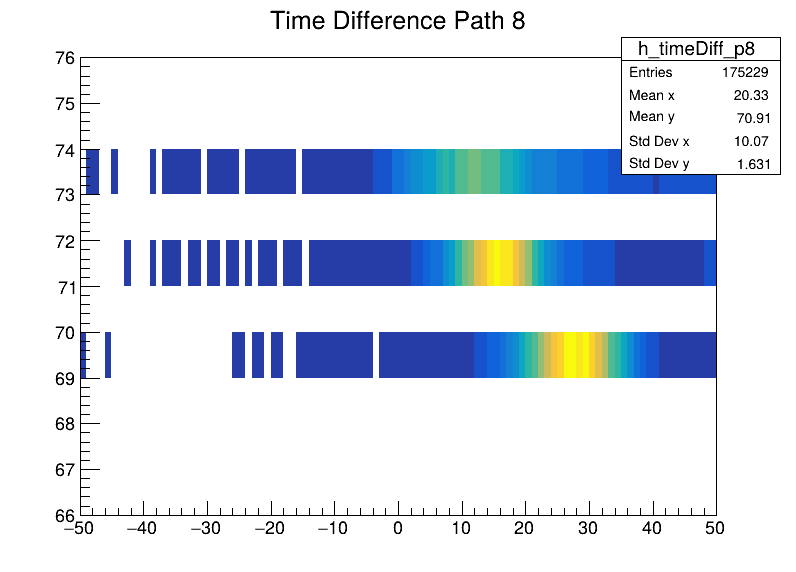

In [7]:
h_timeDiffs[8].Draw()
c1.Draw()

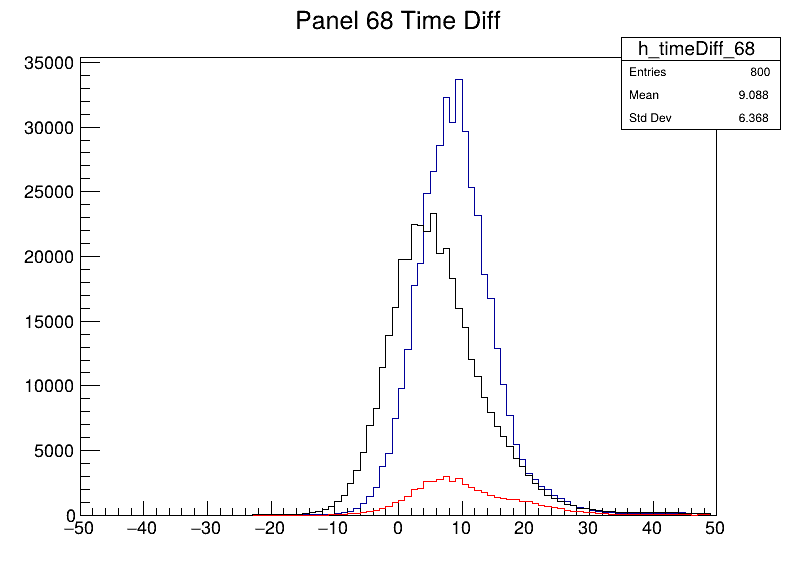

In [8]:
h_timeDiff_68.Draw()
h_timeDiff_70.SetLineColor(r.kRed)
h_timeDiff_72.SetLineColor(r.kBlack)
h_timeDiff_70.Draw("same")
h_timeDiff_72.Draw("same")
c1.Draw()

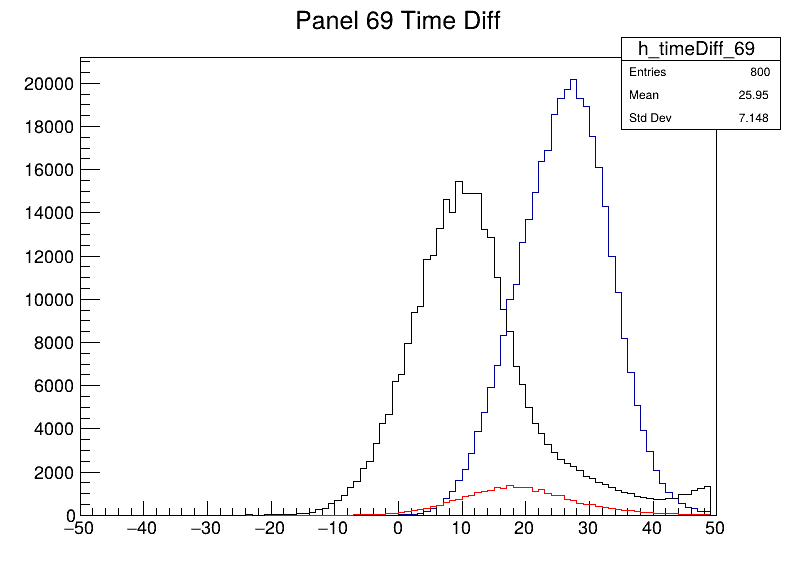

In [9]:
h_timeDiff_69.Draw()
h_timeDiff_71.SetLineColor(r.kRed)
h_timeDiff_73.SetLineColor(r.kBlack)
h_timeDiff_71.Draw("same")
h_timeDiff_73.Draw("same")
c1.Draw()

In [10]:
h_panelTimes = [h_timeDiff_68, h_timeDiff_69, h_timeDiff_70, h_timeDiff_71, h_timeDiff_72, h_timeDiff_73]
fits = []
for i, panel in enumerate(range(68, 74)):
    f = r.TF1(f"f_{panel}", "gaus", -50, 50)
    if panel == 70:
        h_panelTimes[i].Fit(f"f_{panel}", "S", "", -50, 10)
    else:
        h_panelTimes[i].Fit(f"f_{panel}", "S", "", -50, 50)
    fits.append(f)

    mean = round(f.GetParameter(1), 2)
    print(f"Panel {panel} Mean Fit: {mean}")

Panel 68 Mean Fit: 8.67
Panel 69 Mean Fit: 25.98
Panel 70 Mean Fit: 8.13
Panel 71 Mean Fit: 18.82
Panel 72 Mean Fit: 5.68
Panel 73 Mean Fit: 10.21
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      10789.2
NDf                       =           94
Edm                       =  3.51481e-07
NCalls                    =           82
Constant                  =      30702.6   +/-   60.9429     
Mean                      =      8.66604   +/-   0.008658    
Sigma                     =      5.46921   +/-   0.0068386    	 (limited)
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      2159.02
NDf                       =           93
Edm                       =  2.81683e-07
NCalls                    =           64
Constant                  =      19878.2   +/-   40.5823     
Mean                      =      25.9842   +/-   0.0120164   
Sigma                     =      7.08064   +/-   0.00822233  

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


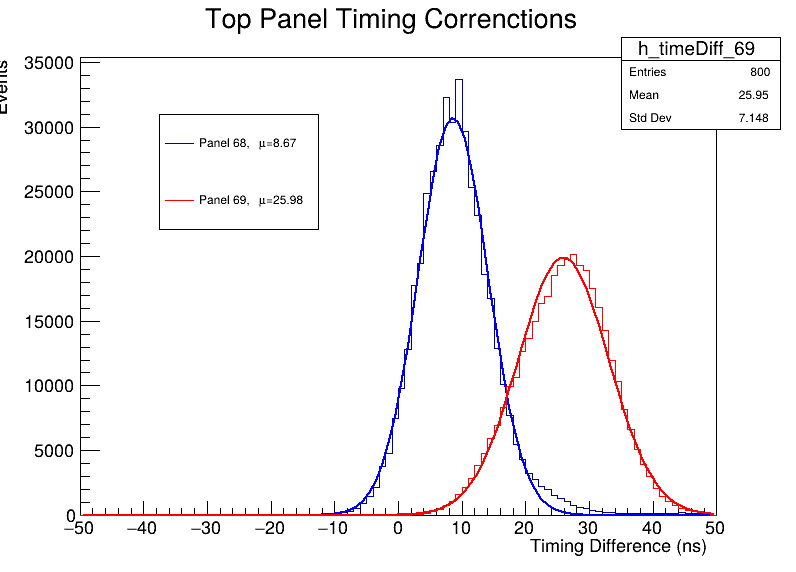

In [11]:
c1 = r.TCanvas("c1", "c1", 800, 600)
c1.cd()
r.gStyle.SetOptStat(0)
h_panelTimes[0].SetTitle("Top Panel Timing Correnctions")
h_panelTimes[0].GetXaxis().SetTitle("Timing Difference (ns)")
h_panelTimes[0].GetYaxis().SetTitle("Events")
h_panelTimes[0].Draw()
fits[0].SetLineColor(r.kBlue)
fits[0].Draw("same")
h_panelTimes[1].SetLineColor(r.kRed)
h_panelTimes[1].Draw("same")

mean_68 = round(fits[0].GetParameter(1), 2)
mean_69 = round(fits[1].GetParameter(1), 2)

l1 = r.TLegend(0.2, 0.6, 0.4, 0.8)
l1.AddEntry(h_panelTimes[0], f"Panel 68, #mu={mean_68}", "l")
l1.AddEntry(h_panelTimes[1], f"Panel 69, #mu={mean_69}", "l")
l1.Draw()
c1.Draw()

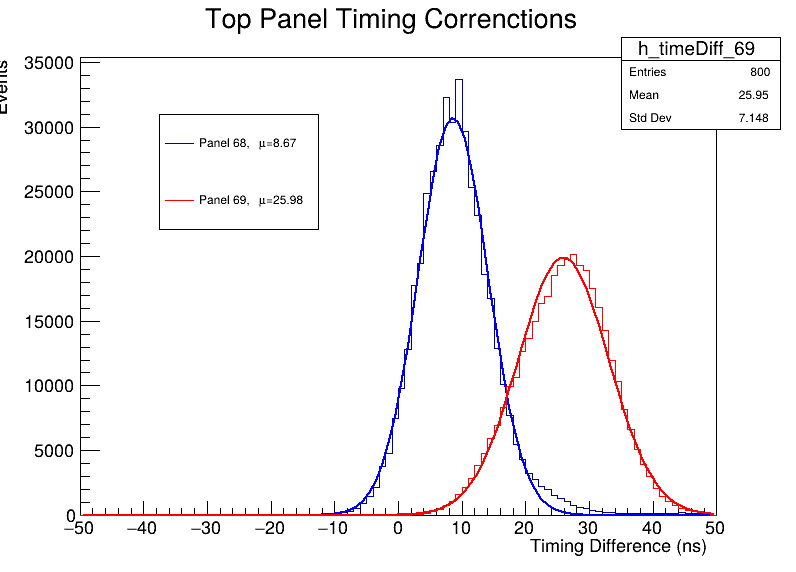

In [12]:
c1.Draw()

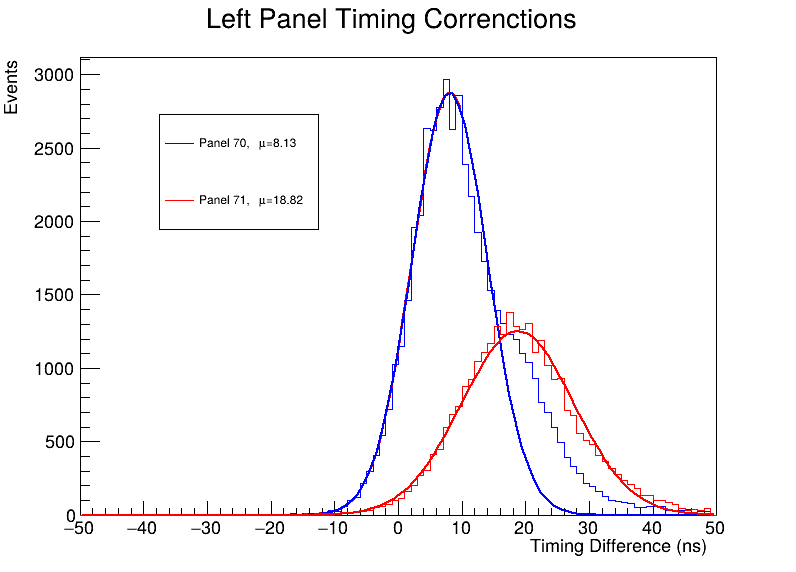

In [13]:
c2 = r.TCanvas("c2", "c2", 800, 600)
c2.cd()
r.gStyle.SetOptStat(0)
h_panelTimes[2].SetTitle("Left Panel Timing Correnctions")
h_panelTimes[2].GetXaxis().SetTitle("Timing Difference (ns)")
h_panelTimes[2].GetYaxis().SetTitle("Events")
h_panelTimes[2].SetLineColor(r.kBlue)
h_panelTimes[2].Draw()
fits[2].SetLineColor(r.kBlue)
fits[2].Draw("same")
h_panelTimes[3].SetLineColor(r.kRed)
h_panelTimes[3].Draw("same")

mean_70 = round(fits[2].GetParameter(1), 2)
mean_71 = round(fits[3].GetParameter(1), 2)

l2 = r.TLegend(0.2, 0.6, 0.4, 0.8)
l2.AddEntry(h_panelTimes[2], f"Panel 70, #mu={mean_70}", "l")
l2.AddEntry(h_panelTimes[3], f"Panel 71, #mu={mean_71}", "l")
l2.Draw()
c2.Draw()

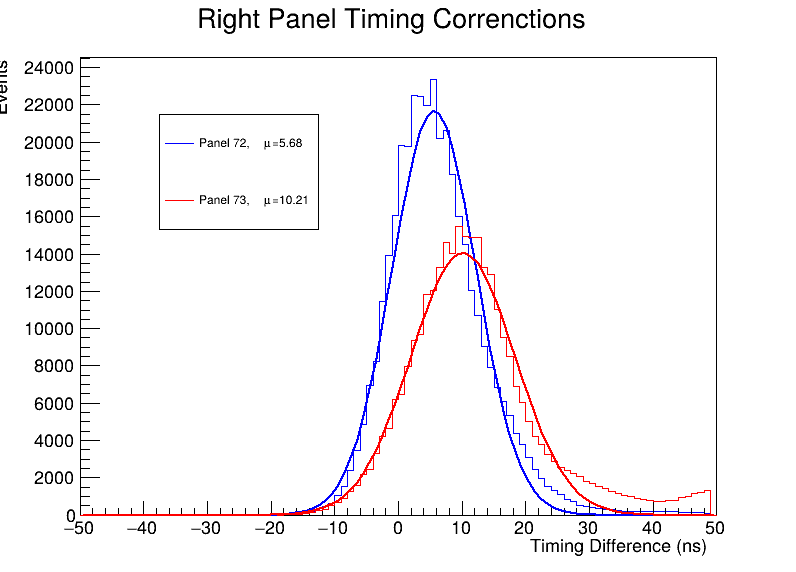

In [14]:
c3 = r.TCanvas("c3", "c3", 800, 600)
c3.cd()
r.gStyle.SetOptStat(0)
h_panelTimes[4].SetTitle("Right Panel Timing Correnctions")
h_panelTimes[4].GetXaxis().SetTitle("Timing Difference (ns)")
h_panelTimes[4].GetYaxis().SetTitle("Events")
h_panelTimes[4].SetLineColor(r.kBlue)
h_panelTimes[4].Draw()
fits[4].SetLineColor(r.kBlue)
fits[4].Draw("same")
h_panelTimes[5].SetLineColor(r.kRed)
h_panelTimes[5].Draw("same")

mean_72 = round(fits[4].GetParameter(1), 2)
mean_73 = round(fits[5].GetParameter(1), 2)

l3 = r.TLegend(0.2, 0.6, 0.4, 0.8)
l3.AddEntry(h_panelTimes[4], f"Panel 72, #mu={mean_72}", "l")
l3.AddEntry(h_panelTimes[5], f"Panel 73, #mu={mean_73}", "l")
l3.Draw()
c3.Draw()

In [15]:
fout = r.TFile.Open("panelFits.root", "recreate")

fout.cd()
c1.Write("topPanels")
c2.Write("leftPanels")
c3.Write("rightPanels")
for h in h_panelTimes:
    h.Write()
for f in fits:
    f.Write()

fout.Close()

In [16]:
fin = r.TFile.Open("panelFits.root")

In [17]:
fin.ls()

TNetXNGFile**		root://eoshome-i03.cern.ch//eos/user/m/micarrig/milliqanOffline/Run3Detector/analysis/timingCalibration/panelFits.root	
 TNetXNGFile*		root://eoshome-i03.cern.ch//eos/user/m/micarrig/milliqanOffline/Run3Detector/analysis/timingCalibration/panelFits.root	
  KEY: TCanvas	topPanels;1	c1
  KEY: TCanvas	leftPanels;1	c2
  KEY: TCanvas	rightPanels;1	c3
  KEY: TH1F	h_timeDiff_68;1	Top Panel Timing Correnctions
  KEY: TH1F	h_timeDiff_69;1	Panel 69 Time Diff
  KEY: TH1F	h_timeDiff_70;1	Left Panel Timing Correnctions
  KEY: TH1F	h_timeDiff_71;1	Panel 71 Time Diff
  KEY: TH1F	h_timeDiff_72;1	Right Panel Timing Correnctions
  KEY: TH1F	h_timeDiff_73;1	Panel 73 Time Diff
  KEY: TF1	f_68;1	gaus
  KEY: TF1	f_69;1	gaus
  KEY: TF1	f_70;1	gaus
  KEY: TF1	f_71;1	gaus
  KEY: TF1	f_72;1	gaus
  KEY: TF1	f_73;1	gaus


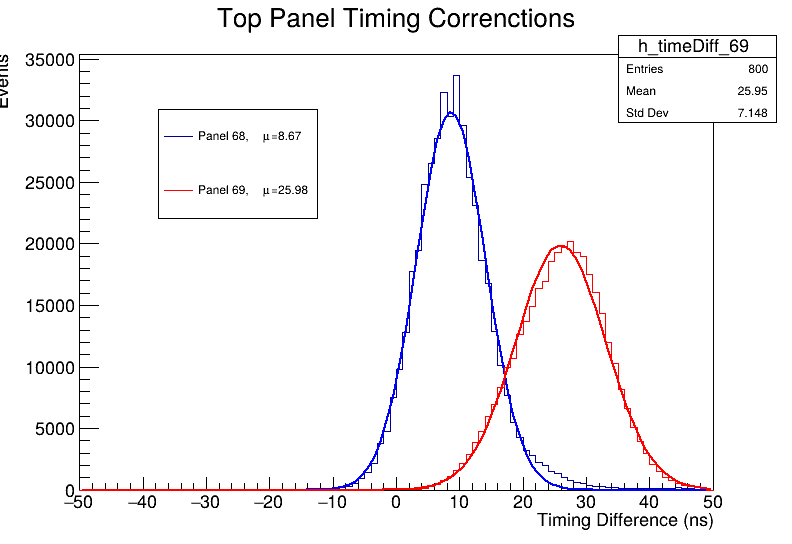

In [18]:
topPanels = fin.Get("topPanels")
topPanels.Draw()


In [ ]:
#also need to calibrate rear panel (channel 75)

In [30]:
@mqCut
def beamPanelTimeDiff(self):

    beamPanelsHit = (ak.any(self.events['chan'] == 74, axis=1)) & (ak.any(self.events['chan'] == 75, axis=1))

    passingEvent = (self.events['straightLineCut']) & (beamPanelsHit)

    backPanelMask = passingEvent & (self.events['chan'] == 75)
    frontPanelMask = passingEvent & (self.events['chan'] == 74)

    frontTimes = self.events['timeFit'][frontPanelMask]
    backTimes = self.events['timeFit'][backPanelMask]

    timeDiff = frontTimes - backTimes

    print(timeDiff)

    self.events['backPanelTimeDiff'] = timeDiff
    

In [33]:
if __name__ == "__main__":

    filelist = [
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1400_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1500_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1600_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1700_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1800_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1900_v35_beam_beamOn_tight.root',
    ]

    print("Running on files {}".format(filelist))

    #define the necessary branches to run over
    branches = ['event', 'tTrigger', 'boardsMatched', 'pickupFlag', 'pickupFlagTight', 'fileNumber', 'runNumber', 'type', 'ipulse', 'nPE', 'chan',
                'time_module_calibrated', 'timeFit_module_calibrated', 'row', 'column', 'layer', 'height', 'area', 'npulses', 'timeFit']


    #define the milliqan cuts object
    mycuts = milliqanCuts()

    setattr(milliqanCuts, "beamPanelTimeDiff", beamPanelTimeDiff)

    #require pulses are not pickup
    pickupCut = getCutMod(mycuts.pickupCut, mycuts, 'pickupCut', tight=True, cut=True, branches=branches)

    #require that all digitizer boards are matched
    boardMatchCut = getCutMod(mycuts.boardsMatched, mycuts, 'boardMatchCut', cut=True, branches=branches)

    #greater than or equal to one hit per layer
    hitInAllLayers = getCutMod(mycuts.oneHitPerLayerCut, mycuts, 'hitInAllLayers', cut=True, branches=branches, multipleHits=False)

    #exactly one hit per layer
    oneHitPerLayer = getCutMod(mycuts.oneHitPerLayerCut, mycuts, 'oneHitPerLayer', cut=True, branches=branches, multipleHits=False)

    #four layer cut
    fourLayerCut = getCutMod(mycuts.fourLayerCut, mycuts, 'fourLayerCut', cut=True, branches=branches)

    #panel veto
    panelVeto = getCutMod(mycuts.panelVeto, mycuts, 'panelVeto', nPECut=40e3, cut=True, branches=branches)

    #nPE Cut
    nPECut = getCutMod(mycuts.nPECut, mycuts, 'nPECut', nPECut=100, cut=True, branches=branches)

    #area cut
    areaCut = getCutMod(mycuts.areaCut, mycuts, 'areaCut', areaCut=300000, cut=True, branches=branches)

    #first pulse cut
    firstPulseCut = getCutMod(mycuts.firstPulseCut, mycuts, 'firstPulseCut', cut=True, branches=branches)

    #require front panel has hit
    #frontPanelHit = getCutMod(mycuts.frontPanelHit, mycuts, 'frontPanelHit', cut=True, branches=branches)

    #require hit time is in trigger window
    centralTime = getCutMod(mycuts.centralTime, mycuts, 'centralTime', cut=True, branches=branches)

    straightLineCut = getCutMod(mycuts.straightLineCut, mycuts, 'straightLineCut', cut=True, branches=branches)

    nbins = 100
    minx = -50
    maxx = 50
    h_backPanelTimeDiff = r.TH1F('h_backPanelTimeDiff', 'Time Difference Back Panel (Chan 75)'.format(i), nbins, minx, maxx)
    
    cutflow = [mycuts.totalEventCounter, mycuts.fullEventCounter, 
                boardMatchCut, 
                pickupCut, 
                firstPulseCut,
                nPECut,
                centralTime,
                straightLineCut,
                mycuts.beamPanelTimeDiff,
                #fourLayerCut,
                #frontPanelHit,
                #mycuts.straightLineCut, 
                #mycuts.pulseTime,
                #mycuts.threeInLine,
                #mycuts.timeDiff,
                #mycuts.getTimeDiffs
            ]
    
    #define milliqan plotter
    myplotter = milliqanPlotter()
    myplotter.dict.clear()

    #myplotter.addHistograms(h_channels, 'chan')
    #myplotter.addHistograms(h_timeDiff, 'timeDiff')
    #myplotter.addHistograms(h_timeDiffNoCorr, 'timeDiffNoCorr')
    #myplotter.addHistograms(h_timeDiffOld, 'timeDiffOld')

    myplotter.addHistograms(h_backPanelTimeDiff, 'backPanelTimeDiff')

    for key, value in myplotter.dict.items():
        if value not in cutflow:
            cutflow.append(value)

    #create a schedule of the cuts
    myschedule = milliQanScheduler(cutflow, mycuts, myplotter)

    #print out the schedule
    myschedule.printSchedule()

    #create the milliqan processor object
    myiterator = milliqanProcessor(filelist, branches, myschedule, step_size=10000, qualityLevel='override')

    #run the milliqan processor
    myiterator.run()

    myschedule.cutFlowPlots()

    #save plots
    myplotter.saveHistograms("backPanelTimingCorrection{}.root".format('_beamOff'))

    mycuts.getCutflowCounts()


Running on files ['/eos/experiment/milliqan/skims/beam/MilliQan_Run1400_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1500_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1600_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1700_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1800_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1900_v35_beam_beamOn_tight.root']
----------------------------
MilliQan Scheduler:
	0. totalEventCounter
	1. fullEventCounter
	2. boardMatchCut
	3. pickupCut
	4. firstPulseCut
	5. nPECut
	6. centralTime
	7. straightLineCut
	8. beamPanelTimeDiff
	9. h_backPanelTimeDiff
----------------------------

Chosen quality level:  override 
Chosen verbosity level:  minimal 


Quality check is being overridden. All files will be processed.
MilliQan Processor: Processing event 0...
[[], [], [], [], [], [], [], [], [], ..., []

Warning in <TROOT::Append>: Replacing existing TH1: h_backPanelTimeDiff (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: eventCutFlow (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: pulseCutFlow (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: eventCutEfficiencies (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: pulseCutEfficiencies (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


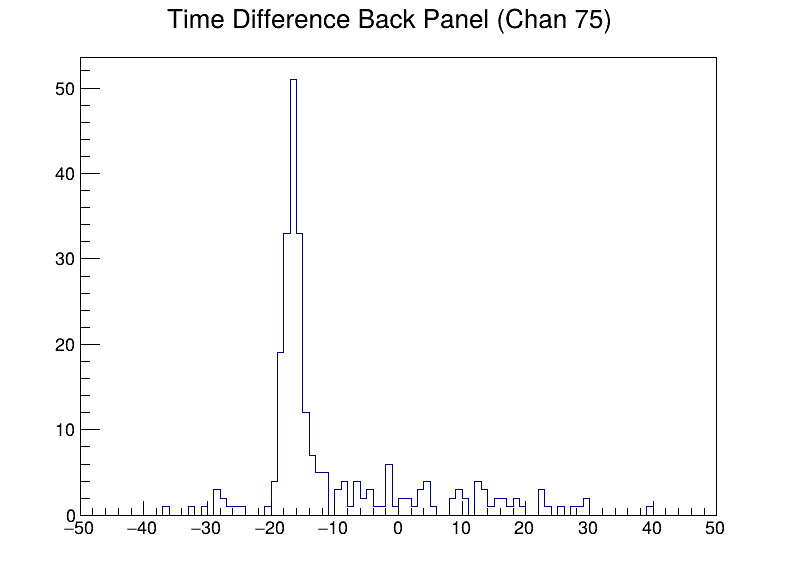

In [34]:
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_backPanelTimeDiff.Draw()
c1.Draw()

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      57.0447
NDf                       =           26
Edm                       =  1.71513e-07
NCalls                    =          135
Constant                  =      44.5126   +/-   4.85999     
Mean                      =     -16.5437   +/-   0.117825    
Sigma                     =      1.41664   +/-   0.106631     	 (limited)


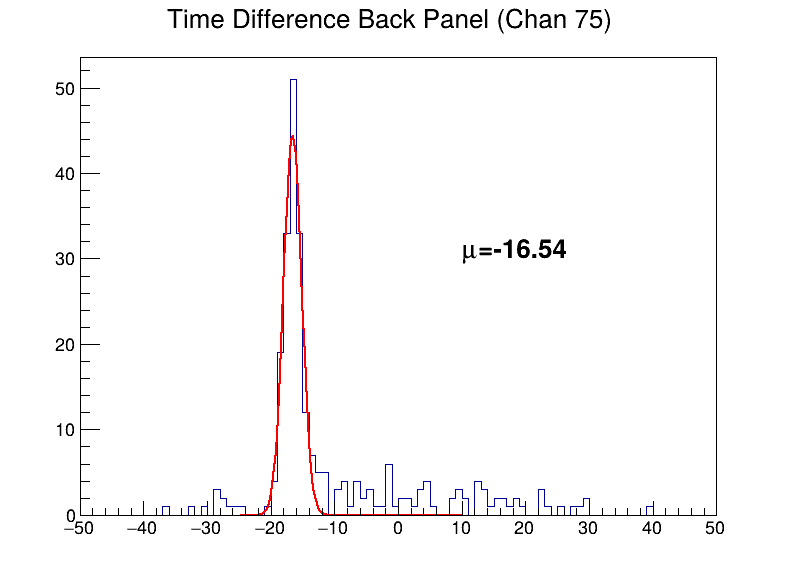

In [37]:
f1 = r.TF1('f1', 'gaus', -30, 30)

h_backPanelTimeDiff.Fit(f1, 's', '', -25, 10)
h_backPanelTimeDiff.Draw()

mean = round(f1.GetParameter(1), 2)
t1 = r.TLatex()
t1.DrawLatex(10, 30, f"#mu={mean}")

c1.Draw()